In [ ]:
from gcl_sem.datasets import MslsCityImagePair

msls_root = "/deepstore/datasets/dmb/ComputerVision/nis-data/acvpr-msls"
masks = "/home/s3155900/gregory/mask_caches/deeplabv3plus_resnet101"


d = MslsCityImagePair(msls_root, "sf")

In [ ]:
import matplotlib.pyplot as plt
import random

# pick random sample in dataset

index = random.randint(0, len(d) - 1)

img0, img1, sim = d[index]

img0 = img0.permute(1, 2, 0)
img1 = img1.permute(1, 2, 0)

img0 = img0 - img0.min()
img0 = img0 / img0.max()

img1 = img1 - img1.min()
img1 = img1 / img1.max()

print(sim)

plt.imshow(img0)
plt.show()

plt.imshow(img1)
plt.show()

# plt.imshow(mask)
# plt.show()

## Loads image-mask pairs

In [ ]:
from gcl_sem.datasets import MslsCityImageMaskPair

msls_root = "/deepstore/datasets/dmb/ComputerVision/nis-data/acvpr-msls"
masks = "/home/s3155900/gregory/mask_caches/deeplabv3plus_resnet101"


d = MslsCityImageMaskPair(msls_root, masks, "sf")

# pick 20 random indices
import random

indices = random.sample(range(len(d)), 20)

for i in indices:
    img_mask0, img_mask1, sim = d[i]

    img0, mask0 = img_mask0[0:3, :, :], img_mask0[3, :, :]
    img1, mask1 = img_mask1[0:3, :, :], img_mask1[3, :, :]


    # scale between 0 and 1
    img0 = img0 - img0.min()
    img0 = img0 / img0.max()

    img1 = img1 - img1.min()
    img1 = img1 / img1.max()

    import matplotlib.pyplot as plt

    # 2x2 grid

    fig, axs = plt.subplots(2, 2)

    print(sim)

    axs[0, 0].imshow(img0.permute(1, 2, 0))
    axs[0, 0].set_title("Image 0")

    axs[0, 1].imshow(mask0)
    axs[0, 1].set_title("Mask 0")

    axs[1, 0].imshow(img1.permute(1, 2, 0))
    axs[1, 0].set_title("Image 1")

    axs[1, 1].imshow(mask1)
    axs[1, 1].set_title("Mask 1")

    plt.show()


## Weird semantic segmentation activations

Number of positive pairs before removing panos: 35712
Number of positive pairs after removing panos: 35521
Number of soft negative pairs before removing panos: 66958
Number of soft negative pairs after removing panos: 66679
Number of hard negative pairs: 17761
Number of pairs: 71042
Similarity: 0.6455078125


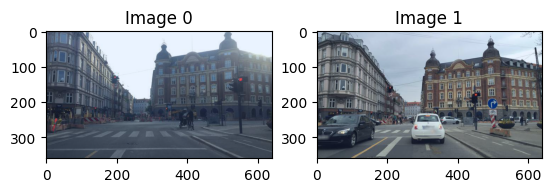

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Dropdown(descriptio…

In [2]:
from gcl_sem.datasets import MslsCitiesImageActPair

from gcl_sem.libs.deeplabv3plus_pytorch.datasets.cityscapes import Cityscapes
import torch

from ipywidgets import interact, widgets

msls_root = "/deepstore/datasets/dmb/ComputerVision/nis-data/acvpr-msls"
activations_root = "/home/s3155900/gregory/mask_caches/deeplabv3plus_resnet101_all_channels_jpg"

# get channel names from Cityscapes dataset
channel_names = [
    c.name 
    for c in Cityscapes.classes
    if c.train_id != 255
]

# not all cities have been processed yet...
d = MslsCitiesImageActPair(msls_root, activations_root, ["cph"])

import matplotlib.pyplot as plt

im0, im1, sim = d[123]

img0, img1 = im0[0:3, :, :], im1[0:3, :, :]
img0, img1 = img0.permute(1, 2, 0), img1.permute(1, 2, 0)

img0 = img0 - img0.min()
img0 = img0 / img0.max()

img1 = img1 - img1.min()
img1 = img1 / img1.max()

activations_left, activations_right = im0[3:, :, :], im1[3:, :, :]

# find smallest and largest values and convert to float
min_activation = min(activations_left.min(), activations_right.min()).item()
max_activation = max(activations_left.max(), activations_right.max()).item()

print(f"Similarity: {sim}")

# 2 columns, 20 rows
fig, axs = plt.subplots(1, 2)

axs[0].imshow(img0)
axs[0].set_title("Image 0")

axs[1].imshow(img1)
axs[1].set_title("Image 1")

def show_masked_image(threshold, channel):

    j = channel

    print(f"channel name: {channel_names[j]}")
    fig, axs = plt.subplots(1, 2)

    act_left = activations_left[j]
    act_right = activations_right[j]

    axs[0].imshow(act_left)
    axs[1].imshow(act_right)

    # broadcast activations to 3 channels
    b_act_left = torch.stack([act_left, act_left, act_left], dim=2)
    b_act_right = torch.stack([act_right, act_right, act_right], dim=2)

    # soft threshold
    b_act_left = b_act_left > threshold
    b_act_right = b_act_right > threshold

    # multiple image by activation pixel-wise
    img_act_left = img0 * b_act_left
    img_act_right = img1 * b_act_right

    img_act_left = img_act_left - img_act_left.min()
    img_act_left = img_act_left / img_act_left.max()

    img_act_right = img_act_right - img_act_right.min()
    img_act_right = img_act_right / img_act_right.max()


    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(img_act_left)
    axs[1].imshow(img_act_right)


channel_choices = [(c, i) for i, c in enumerate(channel_names)]

# create threshold slider and a drop-down menu for selecting channels
interact(show_masked_image, threshold=(min_activation, max_activation, 0.01), channel=channel_choices)


plt.show()